In [9]:
import sys
from os.path import dirname
current_location = sys.path[0]
sys.path.append(dirname(dirname(current_location)) + "/lib")
sys.path.append(dirname(current_location) + "/lib")

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import time
from IPython.display import display, Math, Latex

import pickle
import nested_formula
import explore
import auxiliary_functions

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [11]:
FOLDER = "first estimation/"

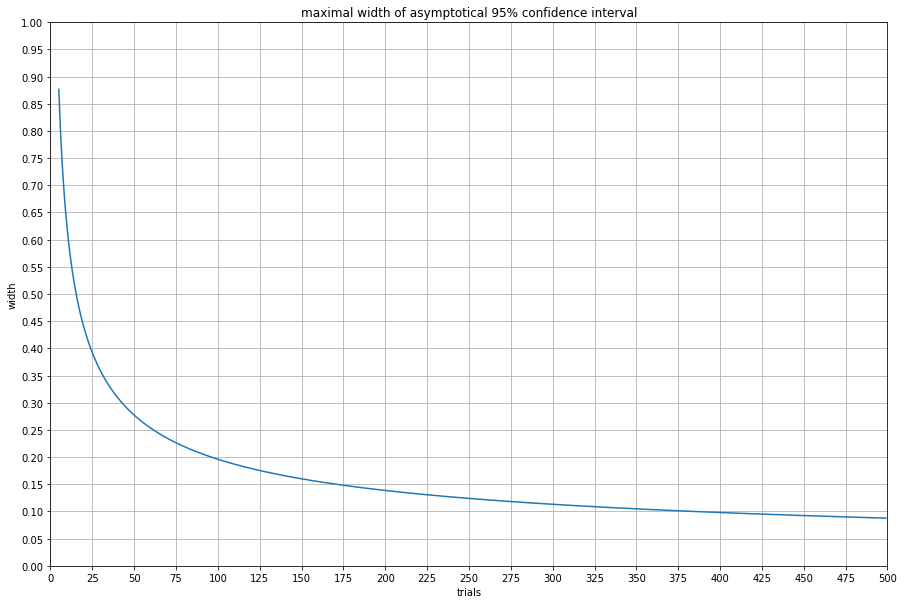

In [31]:
grid = np.arange(5, 500)
y = 1.96 * np.sqrt(1 / grid)
plt.figure(figsize=(15, 10))
plt.plot(grid, y)
plt.xlim(0, 500)
plt.ylim(0, 1)
plt.xticks(np.linspace(0, 500, 21))
plt.yticks(np.linspace(0, 1, 21))
plt.xlabel("trials")
plt.ylabel("width")
plt.title("maximal width of asymptotical 95% confidence interval")
plt.grid()
plt.show()

In [12]:
possible = True
file_number = 0
data = []
for file_number in range(1, 76):
    with open(FOLDER + "results" + str(file_number) + ".pkl", "rb") as fin:
        data.append(pickle.load(fin))

In [4]:
data

[{10: {2: [0.8, 0.8, 0.8], 3: [0.2, 0.0, 0.6], 4: [0.0, 0.0, 0.0]},
  100: {2: [0.6, 1.0, 0.6], 3: [0.4, 0.8, 1.0], 4: [0.6, 0.8, 0.0]},
  1000: {2: [1.0, 0.8, 0.8], 3: [0.4, 0.6, 0.4], 4: [0.6, 0.6, 0.6]}},
 {10: {2: [0.6, 1.0, 0.8], 3: [0.4, 0.0, 0.0], 4: [0.0, 0.2, 0.0]},
  100: {2: [1.0, 1.0, 0.8], 3: [0.6, 0.8, 0.6], 4: [0.2, 0.2, 0.2]},
  1000: {2: [0.6, 0.8, 0.6], 3: [0.2, 0.6, 1.0], 4: [0.4, 0.2, 0.4]}},
 {10: {2: [0.6, 0.4, 0.4], 3: [0.4, 0.4, 0.0], 4: [0.2, 0.2, 0.2]},
  100: {2: [0.6, 1.0, 0.4], 3: [0.6, 0.6, 0.0], 4: [0.4, 0.4, 0.2]},
  1000: {2: [0.8, 0.8, 0.8], 3: [0.6, 0.6, 0.6], 4: [0.4, 0.6, 0.2]}},
 {10: {2: [0.8, 0.8, 0.4], 3: [0.4, 0.2, 0.0], 4: [0.2, 0.0, 0.0]},
  100: {2: [1.0, 0.4, 0.8], 3: [0.8, 0.8, 1.0], 4: [0.6, 0.8, 0.2]},
  1000: {2: [0.8, 0.8, 1.0], 3: [0.8, 0.6, 0.4], 4: [0.4, 0.2, 0.4]}},
 {10: {2: [0.6, 0.6, 0.8], 3: [0.6, 0.8, 0.0], 4: [0.0, 0.0, 0.0]},
  100: {2: [1.0, 0.8, 1.0], 3: [0.8, 0.2, 0.6], 4: [0.4, 0.8, 0.2]},
  1000: {2: [0.8, 1.0, 0.8], 3:

In [13]:
results = {}
for m_samples in [10, 100, 1000]:
    results[m_samples] = {}
    for n_variables in range(2, 5):
        results[m_samples][n_variables] = np.array([0., 0., 0.])
        for i in range(file_number):
            results[m_samples][n_variables] += np.array(
                data[i][m_samples][n_variables])
        results[m_samples][n_variables] /= 75

In [14]:
se = {}
for m_samples in [10, 100, 1000]:
    se[m_samples] = {}
    for n_variables in range(2, 5):
        a = np.array(results[m_samples][n_variables])
        se[m_samples][n_variables] = np.sqrt(a * (1 - a) / (file_number * 5))

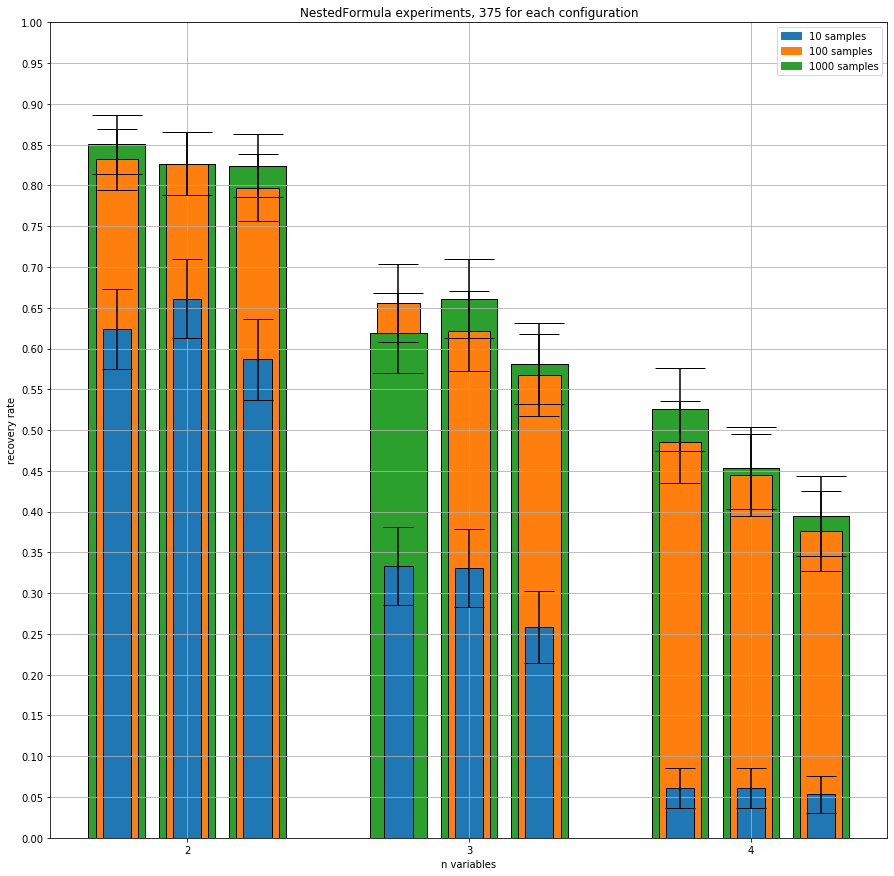

In [15]:
import numpy as np
import matplotlib.pyplot as plt


def plot_diagram(alpha=1):
    for powers_type in range(3):
        position = np.arange(2, 5) + (powers_type - 1) / 4

        heights_a = [
            pd.DataFrame(results).loc[:, 10][i][powers_type] for i in (2, 3, 4)
        ]
        heights_b = [
            pd.DataFrame(results).loc[:, 100][i][powers_type]
            for i in (2, 3, 4)
        ]
        heights_c = [
            pd.DataFrame(results).loc[:, 1000][i][powers_type]
            for i in (2, 3, 4)
        ]

        se_a = [pd.DataFrame(se).loc[:, 10][i][powers_type] for i in (2, 3, 4)]
        se_b = [
            pd.DataFrame(se).loc[:, 100][i][powers_type] for i in (2, 3, 4)
        ]
        se_c = [
            pd.DataFrame(se).loc[:, 1000][i][powers_type] for i in (2, 3, 4)
        ]

        for x, ha, hb, hc, sea, seb, sec in zip(position, heights_a, heights_b,
                                                heights_c, se_a, se_b, se_c):
            for i, (h, serr, c, ec, width, capsize) in enumerate(
                    sorted(
                        zip([ha, hb, hc], [sea, seb, sec], colors, ecolors,
                            widths, capsizes))):
                if alpha:
                    plt.bar(x,
                            h,
                            color=c,
                            alpha=alpha,
                            zorder=-i,
                            width=width,
                            edgecolor='black')
                else:
                    plt.bar(x,
                            h,
                            yerr=1.96 * serr,
                            color=c,
                            alpha=alpha,
                            capsize=capsize,
                            width=width,
                            edgecolor='black')


barwidth = 0.2
a = np.arange(-1, 2) / 4
colors = ['C0', 'C1', 'C2']
ecolors = ['C3', 'C4', 'C5']
# colors = [1, 2, 3]
patches = []
plt.figure(figsize=(15, 15))
for i in range(3):
    patches.append(
        mpatches.Patch(color=colors[i], label=str(10**(i + 1)) + " samples"))

widths = [0.1, 0.15, 0.2]
capsizes = [15, 20, 25]

plt.xlabel('n variables')
plt.ylabel('recovery rate')
plt.xticks([2, 3, 4])
plt.yticks(np.linspace(0, 1, 21))
plt.ylim(0, 1)
plt.grid()
plt.title("NestedFormula experiments, " + str(file_number * 5) +
          " for each configuration")
plt.legend(handles=patches)
plot_diagram(0)
plot_diagram(1)
plt.savefig(FOLDER + "diagram.jpeg")
plt.show()